In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

import pickle

# Data cleaning 

In [2]:
# Read the data and replace '-' with Nan
companies = pd.read_csv('Data/Raw Data/companies.csv', na_values='-' )
acquisitions = pd.read_csv('Data/Raw Data/acquisitions.csv')
additions = pd.read_csv('Data/Raw Data/additions.csv')
investments = pd.read_csv('Data/Raw Data/investments.csv')
rounds = pd.read_csv('Data/Raw Data/rounds.csv')
companies.shape

(66368, 14)

In [3]:
companies.head(1)

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05


Designing from Venture Capital point of view:

- Only keep companies with at least one round of funding 
- Only keep records that have received funding: non-missing and non-zero values

In [4]:
# 1. Drop NaNs from 'funding_total_usd' and convert to integer 
companies.dropna(subset = ['funding_total_usd'], inplace=True)
companies['funding_total_usd'] = companies['funding_total_usd'].astype(int)

# 2. Filter the data as described above and store in 'target_companies'
target_companies = companies[(companies['funding_rounds']>0) & 
                             (companies['funding_total_usd']>0)]
target_companies.shape

(53583, 14)

For more analysis and design, convert the dates columns to date type:


In [5]:
# 1. First delete the handful of NaN's and invalid dates
target_companies.dropna(subset = ['first_funding_at', 'last_funding_at'], inplace=True)
target_companies = target_companies[~target_companies['first_funding_at'].isin(['1532-06-26','1014-03-01'])]

# 2. Convert to date type
target_companies['first_funding_at'] = pd.to_datetime(target_companies['first_funding_at'])
target_companies['last_funding_at'] = pd.to_datetime(target_companies['last_funding_at'])

target_companies.shape

(53558, 14)

Let's create new columns for year of first funing and last funding to do furthur analyis with them.

In [6]:
target_companies['first_funding_year'] = target_companies['first_funding_at'].dt.year
target_companies['last_funding_year'] = target_companies['last_funding_at'].dt.year

Let's also create a new column for time between funding rounds. 

In [7]:
target_companies['months_bw_fundings'] = (
                 (target_companies['last_funding_year'] - target_companies['first_funding_year'])*12 +
                 (target_companies['last_funding_at'].dt.month - target_companies['first_funding_at'].dt.month)) 

So far I have included companies that had at least one round of funding. Alternatively, I could filter only for companies that had at least 2 rounds of funding, but as shown below, more than 40% are many companies that were acquired or had an IPO and only received one year of funding. So, I will keep all companies that had only one round of finding.

In [9]:
target_companies[target_companies['status'].isin(['acquired', 'ipo'])]['funding_rounds'].value_counts(4).head(5)

1    0.407384
2    0.239807
3    0.151204
4    0.087801
5    0.047030
Name: funding_rounds, dtype: float64

Need to define failure or success. Let's look at the status of the companies. 

In [10]:
target_companies['status'].value_counts()

operating    42417
closed        4911
acquired      4789
ipo           1441
Name: status, dtype: int64

'IPO' and 'acquired' can interpreted as success and 'closed' can interpreted as failure. 

Need to take a closer look at the operating companies to see if they can be identified as succeeded or failed. Let's look at the distribution of first and last funding year for the operating companies: 

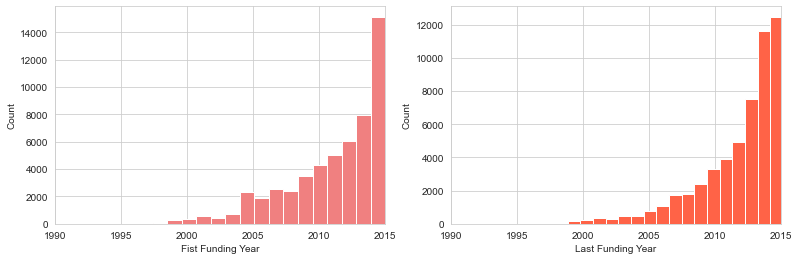

In [44]:
temp = target_companies[target_companies['status'] == 'operating']
plt.figure(figsize=(13,4))

plt.subplot(1,2,1)
plt.hist(target_companies['first_funding_year'], bins = 50, color = 'lightcoral')
plt.xlim(1990, 2015)
plt.xlabel('Fist Funding Year')
plt.ylabel('Count')

plt.subplot(1,2,2)
plt.hist(target_companies['last_funding_year'], bins = 150, color = 'tomato')
plt.xlim(1990, 2015)
plt.xlabel('Last Funding Year')
plt.ylabel('Count');


**Observations and desions points:**
- Some companies that are in operating status have not been funded in the last five or ten years.
- Many companies were funded for the first time only recently.
- We can't really call companies that have not been funded recently but have been operating for a long time unsuccessful. Therefore, it makes more sense to exclude them from the analysis because they do not seem to need funding.
- The companies that were founded recently, but have not received funding in the past 3 years, have not been very successful enough in attracting funding, so I will keep such companies in the data and will label them as failed. 

Note: Avg time between funding rounds for tech companies is 12 to 18 months:
https://medium.com/journal-of-empirical-entrepreneurship/how-much-runway-should-you-target-between-financing-rounds-478b1616cfb5#:~:text=CBInsights%20estimates%20the%20median%20time,to%2D18%20month%20conventional%20wisdom.

In [11]:
# let's see how many companies were last funded before 2012
len(target_companies[ (target_companies['status'] =='operating')  & (target_companies['last_funding_year'] < 2012)])

10354

In [12]:
# Create a dataset of the companies that either 'failed' or'succeeded'.
df = target_companies[(target_companies['status'].isin(['closed','acquired', 'ipo'])) | 
                      
                      ((target_companies['status'] == 'operating') &
                       (target_companies['first_funding_year'] < 2009) & 
                       (target_companies['last_funding_year'] < 2012) 
                      )]

df['status'].value_counts(), len(df)

(closed       4911
 acquired     4789
 operating    4783
 ipo          1441
 Name: status, dtype: int64,
 15924)

Now let's create a Target column to label companies as:
- **Succeeded**: if acquired or had an ipo
- **Failed**: if we're closed or are operating (as discussed above)

Assign 1 to the moniority calss and 0 to the majority class

In [13]:
df['succeeded'] = df['status'].apply(lambda x: 1 if x in ['acquired', 'ipo'] else 0 )
df['succeeded'].value_counts()

<ipython-input-13-485acd6fecd7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['succeeded'] = df['status'].apply(lambda x: 1 if x in ['acquired', 'ipo'] else 0 )


0    9694
1    6230
Name: succeeded, dtype: int64

So far we have identified the target companies and how they should be labeled. Now let's take a look at the outliers:

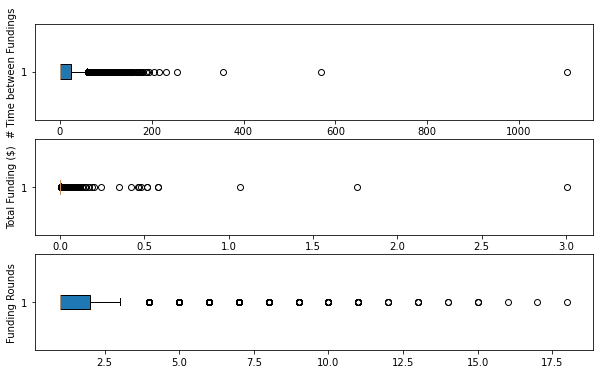

In [14]:
plt.figure(figsize=(10,6))

plt.subplot(3,1,1)
plt.boxplot(df['months_bw_fundings'], patch_artist= True, vert= False)
plt.ylabel('# Time between Fundings')


plt.subplot(3,1,2)
plt.boxplot(df['funding_total_usd'],patch_artist= True, vert= False)
plt.ylabel('Total Funding ($)')

plt.subplot(3,1,3)
plt.boxplot(df['funding_rounds'],patch_artist= True, vert= False)
plt.ylabel('Funding Rounds');

There are too many outliers in the data, need to remove some of them. 

In [15]:
df = df[df['months_bw_fundings'] <250] # less than 150 months
df = df[df['funding_total_usd'] <15000000] # less than 10M
df = df[df['funding_rounds'] <8]
len(df)

10990

This removed ~ 37 % of the data, but should improve the accuracy of the prediction.

In [16]:
# Furthure remove the outliers and pickle this database to test in modeling 
df1 = df[df['months_bw_fundings'] <150]
df1 = df[df['months_bw_fundings'] >0]

#data_path = 'Processd Data\'
df1.to_pickle('Data/Processed Data/companies.pkl')  #("%s/processed/pages.pkl" % data_path)

# Create a second dataset 
(Including the time between being founded and the first funding)

So far, I have created a dataset that includes a column for the time between first funding and last funding. But I think the time between being founded and the first funding could be a more important factor contributing to the success of a  company. However, a lot of the companies in the data are missing the date that they were founded, so I will create a new dataset, including only the companies that have the time between being founded and first funding.

The downside is that this will eliminates any records. So I will test both datasets to see which dataset is better in predicting success.


In [17]:
# Create a new dataset and remove NaN's and invalid dates from founded_at date. 
df2= df.dropna(subset =['founded_at'])

df2 = (df2[~ df2['founded_at'].isin(['1015-01-30', '1636-09-08', '2914-01-01', '1592-01-01'])]
                          )
len(df), len(df2)

(10990, 7741)

In [18]:
# Convert  to date type
df2['founded_at'] = pd.to_datetime(df2['founded_at'])

# Create a new column for year the companies were founded
df2['year_founded'] = df2['founded_at'].dt.year

In [19]:
# Create a new column for the time between when a company was founded and when they recived their first funding. 
df2['months_until_1st_fundings'] =( 
            (df2['first_funding_year'] - df2['year_founded'])*12 +
             df2['first_funding_at'].dt.month - df2['founded_at'].dt.month)

While it is not common, sometimes companies receive funding before they are founded, usually by the founders themselves. However, there could be wrong dates in the data as well, so I will exclude the records that have received funding more than 10 months before being sounded just to have a cleaner database. This will eliminate a small portion of records.

In [20]:
len(df2)

7741

In [21]:
df2= df2[(df2['status'].isin(['closed','acquired', 'ipo'])) | 
          ((df2['status'] == 'operating') & (df2['year_founded'] > 2005))]

In [23]:
df2['status'].value_counts(), len(df2)

(closed       2877
 acquired     2262
 operating     843
 ipo           337
 Name: status, dtype: int64,
 6319)

Text(0, 0.5, '# Months to First Funding')

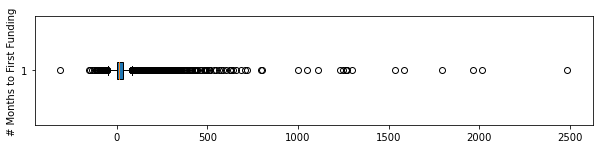

In [24]:
# Look at outliers in df2 dataset since we have not looked at this feature yet.

plt.figure(figsize=(10,2))


plt.boxplot(df2['months_until_1st_fundings'], patch_artist= True, vert= False)
plt.ylabel('# Months to First Funding')


There are many outliers in the months_until_1st_fundings column, need to remove some of them.

In [31]:
df2 = df2[df2['months_until_1st_fundings'] <150]
len(df2)

5968

In [150]:
df2['status'].value_counts(), len(df2)

(closed       2794
 acquired     2148
 operating     843
 ipo           183
 Name: status, dtype: int64,
 5968)

# Let's look at the distribution of company categories, countries, and states

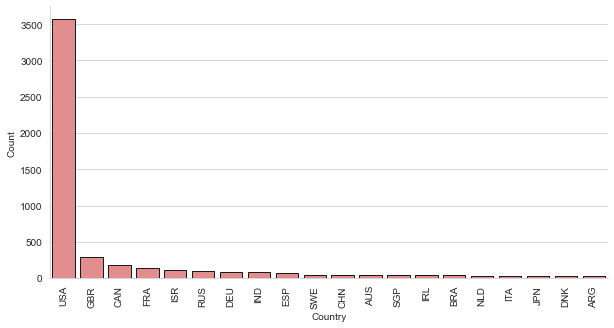

In [32]:
# See the distribution of the countries
countries = (df2.groupby('country_code')['name'].count()
              .reset_index()
              .sort_values('name',ascending = False)).head(20)
countries.columns = ['country_code', 'count']

# Plot the top countries by count
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

sns.barplot(x= 'country_code', y = 'count', data = countries, color='lightcoral', edgecolor='.1')

sns.despine()
plt.xticks(rotation = 90)
plt.xlabel('Country')
plt.ylabel('Count');

In [33]:
# Pickle the top countries to use in modeling
top_countries = countries[countries['count']>80]
top_countries_list = top_countries['country_code'].to_list()
top_countries = pd.DataFrame(top_countries_list, columns= ['countries'])
top_countries.to_pickle('Data/Processed Data/top_countries.pkl')

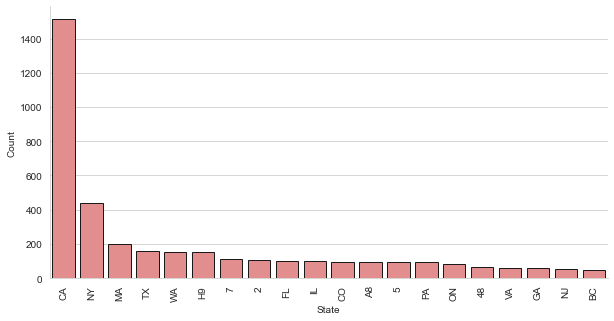

In [34]:
# See the distribution of the states
states = (df2.groupby('state_code')['name'].count()
              .reset_index()
              .sort_values('name',ascending = False)).head(20)

states.columns = ['state_code', 'count']

# Plot the states by count
plt.figure(figsize=(10,5))
sns.set_style('whitegrid')

sns.barplot(x= 'state_code', y = 'count', data = states, color='lightcoral', edgecolor='.1')

sns.despine()
plt.xticks(rotation = 90)
plt.xlabel('State')
plt.ylabel('Count');

In [157]:
# There are some numbers and unknown names in the data, let's take a closer look and see if we can tell what they are
temp_states = pd.read_csv('Data/Raw Data/companies.csv', na_values='-' )
temp_states[temp_states['state_code'].isin(['H9'])][['state_code','region', 'city']].sample(2) 

,state_code,region,city
59965,H9,London,London
3127,H9,London,London


A bit of investigation showed that 'H9' means London. The other numbers included in the top states in the above graph mean multiple international cities. However I will only focous on the top U.S. states in the modeling.

In [158]:
# Pickle the top U.S. states to use in modeling.
top_USA_states = states[states['count']>155]
top_USA_states_list = top_USA_states['state_code'].to_list()
top_USA_states = pd.DataFrame(top_USA_states_list, columns= ['states'])
top_USA_states.to_pickle('Data/Processed Data/top_USA_states.pkl')

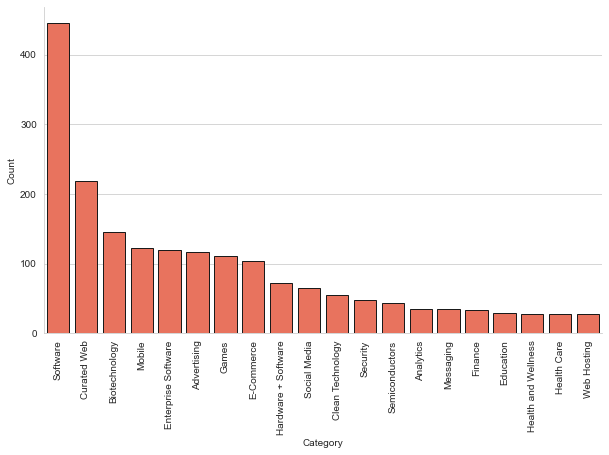

In [104]:
# See the distribution of categories. 
categories = (df2.groupby('category_list')['name'].count()
              .reset_index()
              .sort_values('name',ascending = False)).head(20)

categories.columns = ['category_list', 'count']

# Plot the top categories by count.
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')

sns.barplot(x= 'category_list', y = 'count', data = categories, color='tomato', edgecolor='.1')

sns.despine()
plt.xticks(rotation = 90)
plt.xlabel('Category')
plt.ylabel('Count');

In [160]:
# Pickle the top categories to use in modeling.
top_categories = categories[categories['count']>45]
top_categories_list = top_categories['category_list'].to_list()
top_categories = pd.DataFrame(top_categories_list, columns=['categories'])
top_categories.to_pickle('Data/Processed Data/top_categories.pkl')

In [161]:
top_categories

,categories
0,Software
1,Curated Web
2,Biotechnology
3,Mobile
4,Enterprise Software
5,Advertising
6,Games
7,E-Commerce
8,Hardware + Software
9,Social Media


In [35]:
df2.describe()

,funding_total_usd,funding_rounds,first_funding_year,last_funding_year,months_bw_fundings,succeeded,year_founded,months_until_1st_fundings
count,5.968000e+03,5968.000000,5968.000000,5968.000000,5968.000000,5968.000000,5968.000000,5968.000000
mean,3.243771e+06,1.603385,2009.323056,2010.091823,9.332775,0.390583,2007.788371,20.466823
std,3.877778e+06,0.936049,3.442144,3.335587,17.485991,0.487922,4.488178,32.975428
min,6.000000e+00,1.000000,1971.000000,1971.000000,0.000000,0.000000,1968.000000,-313.000000
25%,2.777050e+05,1.000000,2007.000000,2008.000000,0.000000,0.000000,2006.000000,1.000000
50%,1.430216e+06,1.000000,2009.000000,2010.000000,0.000000,0.000000,2008.000000,10.000000
75%,5.000000e+06,2.000000,2012.000000,2013.000000,13.000000,1.000000,2011.000000,28.000000
max,1.495625e+07,7.000000,2015.000000,2015.000000,182.000000,1.000000,2041.000000,149.000000


In [36]:
# Remove the columns that are not needed for modeling and pickle the data.
df2.drop(['permalink', 'homepage_url', 'region', 'city'], axis = 1, inplace= True)
df2.to_pickle('Data/Processed Data/comps_with_founded_year.pkl')